In [4]:
import sys
sys.path.append('/Users/akuan/Dropbox (HMS)/htem_team/projects/PPC_project/modelling/opponent-inhibition-models')
sys.path.append('/Users/akuan/Dropbox (HMS)/htem_team/projects/PPC_project/modelling/opponent-inhibition-models/modules')
sys.path.append('/Users/akuan/Dropbox (HMS)/htem_team/projects/PPC_project/modelling/opponent-inhibition-models/data')
from RecurrentNets import *
from decoding import *
from numpy import *
from dynamicstools import *
from plottingtools import *
from matplotlib.pyplot import *
from matplotlib import pyplot as plt
import matplotlib
matplotlib.rcParams['pdf.fonttype'] = 42 # Formatting for editable pdf text
matplotlib.rcParams['font.sans-serif']=['Arial']
import seaborn as sns
sns.set_style('ticks')
import rc_parameters
from numpy.linalg import multi_dot, inv, eigvals
from sklearn.metrics import roc_auc_score, auc
from scipy.stats import norm
from scipy import linalg
rcParams.update({
    "text.usetex": False, "axes.spines.top":False, "axes.spines.right":False})
figsDir = '/Users/akuan/Dropbox (HMS)/htem_team/projects/PPC_project/figures_files/final_fig_panels/Fig4/'

In [2]:
## Set up dynamics model
S_EE =0
S_EI =2
S_IE =2
S_II = 0.

D_EE = 0.
D_EI = -0.7
D_IE = 1
D_II =0

S = array([[S_EE, -S_EI],[S_IE, -S_II]])
D = array([[D_EE, -D_EI],[D_IE, -D_II]])
Win = 0.5 * (S + D)
Wout = 0.5 * (S - D)
J = block([[Win, Wout],[Wout, Win]])

DT=20
T = 200+DT
T1,T2 = 70,160
nsteps = 2000
t = linspace(0,T,nsteps)
dt = t[1] - t[0]
N = 4
baseline = 0
c1 = 1
c2 = 0
mu_ns = 0
input = outer(array([baseline,0,baseline,0]), ones(nsteps))
input = input + outer(array([c1,0,c2,0]), ones(nsteps)*(t>T1)*(t<T2))
pars = {'N': N, 't':t, 'R0':zeros(N), 'J':J, 'I':input, 'sigma':0., 'f': lambda x:x}
R = simulate_rate_model(pars)

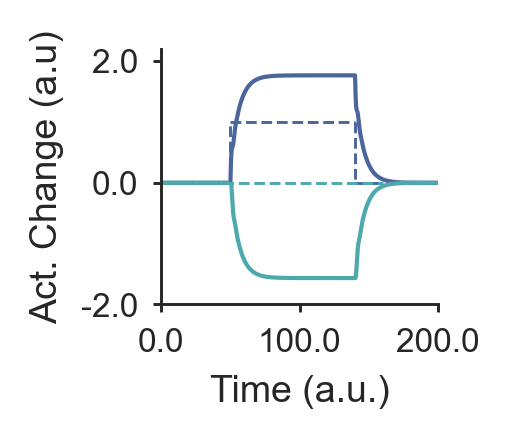

In [7]:
# Fig. 4b: example_dynamics
fig,ax = my_figure(figsize=(1.8,1.5))
matplotlib.rcParams['font.sans-serif']=['Arial']
matplotlib.rcParams['mathtext.fontset'] = 'custom'
matplotlib.rcParams['mathtext.rm'] = 'Arial'

times = arange(int(DT/dt),len(t))

ax.plot(t[times]-DT, R[0,times], color='#4b669c', lw=1, label='E1') # E1
ax.plot(t[times]-DT,R[2,times], color='#4ea9ad', lw=1, label='E2') # E2

ax.set_xlim(0,T-DT)
ylim([-2,2.2])
y2 = ax.get_ylim()[1]
#ax.plot([T1-DT,T2-DT], [y2-0.05, y2-0.05], lw=2.5, color='#777a7a')

plot([0,T1-DT],[0.0,0.0], '--', lw=0.7, c='#4b669c')
plot([T1-DT,T1-DT],[0,1], '--', lw=0.7, c='#4b669c')
plot([T1-DT,T2-DT],[1,1], '--', lw=0.7, c='#4b669c')
plot([T2-DT,T2-DT],[1,0], '--', lw=0.7, c='#4b669c')
plot([T2-DT,T2],[0,0], '--', lw=0.7, c='#4b669c')

plot([0,T2],[0,0], '--', lw=0.7, c='#4ea9ad')

xlabel('Time (a.u.)')
#ylabel('Firing rate \nchange (a.u.)')
ylabel('Act. Change (a.u)')
#legend(frameon=False)
tight_layout()
##
plt.savefig(figsDir+'4b_example_dynamics.pdf',bbox_inches='tight', dpi=300)

In [8]:

print(matplotlib.rcParams['pdf.fonttype'])
print(matplotlib.rcParams['font.sans-serif'])

42
['Arial']


In [9]:
# Set up decoding accuracy model
n = 120 # fine grain ness of model (was 120)
S_EE = 0
S_EI = 2
S_IE = 2
S_II = 0.

D_EE = S_EE
D_EI = linspace(-S_EI, S_EI, n)
D_IE = linspace(0, S_IE, n)
D_II = 0.


selectivity_E1    = empty((len(D_IE),len(D_EI)))
selectivity_E2    = empty((len(D_IE),len(D_EI)))
selectivity_I1    = empty((len(D_IE),len(D_EI)))
selectivity_I2    = empty((len(D_IE),len(D_EI)))
decodacc_E     = empty((len(D_IE),len(D_EI)))
decodacc_EI    = empty((len(D_IE),len(D_EI)))
decodacc_E_sh  = empty((len(D_IE),len(D_EI)))
decodacc_EI_sh = empty((len(D_IE),len(D_EI)))

selectivity_E1_0    = empty((len(D_IE),len(D_EI)))
selectivity_E2_0    = empty((len(D_IE),len(D_EI)))
selectivity_I1_0    = empty((len(D_IE),len(D_EI)))
selectivity_I2_0    = empty((len(D_IE),len(D_EI)))
decodacc_E_0     = empty((len(D_IE),len(D_EI)))
decodacc_EI_0    = empty((len(D_IE),len(D_EI)))
decodacc_E_sh_0  = empty((len(D_IE),len(D_EI)))
decodacc_EI_sh_0 = empty((len(D_IE),len(D_EI)))

amplification = empty((len(D_IE),len(D_EI)))
suppression = empty((len(D_IE),len(D_EI)))

N = 4
sigma_input = 0
sigma_obs = 1
R0 = zeros(N)
f = lambda x:x

for i_EI in range(len(D_EI)):
    for i_IE in range(len(D_IE)):

        if 1 + D_EI[i_EI] * D_IE[i_IE] - D_EE < 1e-10:
            decodacc_EI[i_IE, i_EI]     = nan
            decodacc_E[i_IE, i_EI]      = nan
            decodacc_EI_sh[i_IE, i_EI]  = nan
            decodacc_E_sh[i_IE, i_EI]   = nan

        else:
            # set connectivity matrix
            S    = array([[S_EE, -S_EI], [S_IE, -S_II]])
            D    = array([[D_EE, -D_EI[i_EI]], [D_IE[i_IE], -D_II]])
            Win  = 0.5 * (S + D)
            Wout = 0.5 * (S - D)

            alpha = 1-S_EE+S_EI*S_IE
            delta = 1-D_EE+D_EI[i_EI]*D_IE[i_IE]

            amplification[i_IE, i_EI] = (1/alpha+1/delta)/2
            suppression[i_IE, i_EI] = (1/alpha-1/delta)/2

            J    = block([[Win, Wout], [Wout, Win]])
            Net = RecurrentNet(J, sigma_input)
            _ = Net.covariance()
            dh1 = array([1,0,0,0])
            dh2 = array([0,0,1,0])
            dh = dh1 - dh2

            cov = sigma_obs * eye(N)
            decodacc_EI[i_IE, i_EI], decodacc_EI_sh[i_IE, i_EI] = Net.compute_acc_analytical_obsnoise(dh, cov)
            decodacc_E[i_IE, i_EI], decodacc_E_sh[i_IE, i_EI] = Net.compute_acc_analytical_obsnoise(dh, cov, idx = [0, 2])
            # selectivity_E1[i_IE, i_EI] = Net.compute_selectivity(neuron = 0, stimulus = 0, dh1 = dh1, dh2 = dh2)
            # selectivity_I1[i_IE, i_EI] = Net.compute_selectivity(neuron = 1, stimulus = 0, dh1 = dh1, dh2 = dh2)
            # selectivity_E2[i_IE, i_EI] = Net.compute_selectivity(neuron = 2, stimulus = 0, dh1 = dh1, dh2 = dh2)
            # selectivity_I2[i_IE, i_EI] = Net.compute_selectivity(neuron = 3, stimulus = 0, dh1 = dh1, dh2 = dh2)

            J = zeros((N,N))
            Net = RecurrentNet(J, sigma_input)
            _ = Net.covariance()
            decodacc_EI_0[i_IE, i_EI], decodacc_EI_sh_0[i_IE, i_EI] = Net.compute_acc_analytical_obsnoise(dh, cov)
            decodacc_E_0[i_IE, i_EI], decodacc_E_sh_0[i_IE, i_EI] = Net.compute_acc_analytical_obsnoise(dh, cov, idx=[0, 2])
            # selectivity_E1_0[i_IE, i_EI] = Net.compute_selectivity(neuron = 0, stimulus = 0, dh1 = dh1, dh2 = dh2)
            # selectivity_I1_0[i_IE, i_EI] = Net.compute_selectivity(neuron = 1, stimulus = 0, dh1 = dh1, dh2 = dh2)
            # selectivity_E2_0[i_IE, i_EI] = Net.compute_selectivity(neuron = 2, stimulus = 0, dh1 = dh1, dh2 = dh2)
            # selectivity_I2_0[i_IE, i_EI] = Net.compute_selectivity(neuron = 3, stimulus = 0, dh1 = dh1, dh2 = dh2)

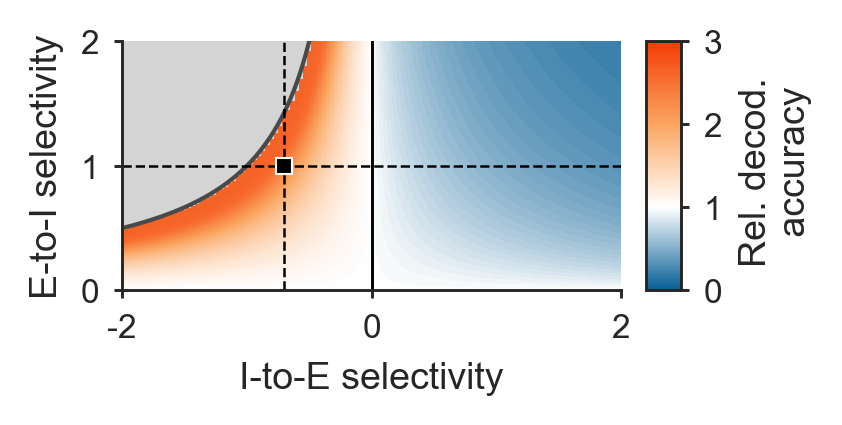

In [11]:
# Fig. 4c: rel decoding accuracy phase plot
##
DD_EI, DD_IE = meshgrid(D_EI, D_IE)
delta = 1 - D_EE + DD_EI*DD_IE

fig,ax = my_figure(figsize=(2.5,1.8))
matplotlib.rcParams['font.sans-serif']=['Arial']
matplotlib.rcParams['mathtext.fontset'] = 'custom'
matplotlib.rcParams['mathtext.rm'] = 'Arial'

format_axes(ax, '0','0')
#colors = ['#086096','w','#c93a60','#851835']
colors = ['#086096','w','#faa661','#f53d05']
cm = define_colormap(colors,100)

Z = abs((decodacc_E-0.5)/(decodacc_E_0-0.5))

Z[delta<0] = nan
cm.set_bad(color='#d4d4d4')

clim = (0,3)
c = ax.imshow(Z,cmap=cm, clim=clim, extent = [min(D_EI),max(D_EI),min(D_IE),max(D_IE)], origin = 'lower')

x1 = linspace(-2,(D_EE-1)/2,1000)
x2 = linspace(-(D_EE-1)/2,2,1000)
ax.plot(x1, (D_EE-1)/x1, lw=1, color='#48494a')

xlim = (-2,2)
ylim = (0,2)

xlabel('I-to-E selectivity')
ylabel('E-to-I selectivity')
plot([0,0],[0,S_IE],'-',color='k', lw=.7)
plot([-2,2],[1,1], lw=0.6, ls='--', color='k')
plot([-0.7,-0.7],[0,2], lw=0.6, ls='--', color='k')
plot([-0.7],[1],'s', markersize=4, markeredgecolor='w', markeredgewidth=0.5, color='k')
tight_layout()

# Put colorbar on right
#cbar = fig.colorbar(c, ticks=(0,1,2,3), fraction=0.025).set_label('Rel. decod. \n accuracy')
from mpl_toolkits.axes_grid1.axes_divider import make_axes_locatable
ax_divider = make_axes_locatable(ax)
# add an axes above the main axes.
cax = ax_divider.append_axes("right", size="7%", pad="5%")
cb = fig.colorbar(c, cax=cax, orientation="vertical",ticks=(0,1,2,3)).set_label('Rel. decod. \n accuracy')
ax.set_xticks([-2,0,+2])

plt.savefig(figsDir+'4c_decod_acc_normalized_obsnoise_phaseplot_half.pdf',bbox_inches='tight', dpi=300)

In [12]:
# setup E-to-I cuts
S_EE = 0.
S_EI = 2
S_IE = 2
S_II = 0.

n = 200
D_EE = S_EE
# D_EI = linspace(-S_EI, S_EI, n)
D_EI = array([-0.7])
D_IE = linspace(0, 2, n)
D_II = 0.

decodacc_E       = empty((len(D_IE),len(D_EI)))
decodacc_EI      = empty((len(D_IE),len(D_EI)))
decodacc_E1      = empty((len(D_IE),len(D_EI)))
decodacc_E2      = empty((len(D_IE),len(D_EI)))
decodacc_I1      = empty((len(D_IE),len(D_EI)))
decodacc_I2      = empty((len(D_IE),len(D_EI)))

decodacc_E_0     = empty((len(D_IE),len(D_EI)))
decodacc_EI_0    = empty((len(D_IE),len(D_EI)))
decodacc_E1_0    = empty((len(D_IE),len(D_EI)))
decodacc_E2_0    = empty((len(D_IE),len(D_EI)))
decodacc_I1_0    = empty((len(D_IE),len(D_EI)))
decodacc_I2_0    = empty((len(D_IE),len(D_EI)))


N = 4
sigma_input = 0
sigma_obs = 2
R0 = zeros(N)
f = lambda x:x

for i_EI in range(len(D_EI)):
    for i_IE in range(len(D_IE)):

        if 1 + D_EI[i_EI] * D_IE[i_IE] - D_EE < 1e-10:
            decodacc_EI[i_IE, i_EI]     = nan
            decodacc_E[i_IE, i_EI]      = nan
            decodacc_EI_0[i_IE, i_EI]   = nan
            decodacc_E_0[i_IE, i_EI]    = nan

            decodacc_E1[i_IE, i_EI]   = nan
            decodacc_E2[i_IE, i_EI]   = nan
            decodacc_E1_0[i_IE, i_EI] = nan
            decodacc_E2_0[i_IE, i_EI] = nan

            decodacc_I1[i_IE, i_EI]   = nan
            decodacc_I2[i_IE, i_EI]   = nan
            decodacc_I1_0[i_IE, i_EI] = nan
            decodacc_I2_0[i_IE, i_EI] = nan

        else:
            S    = array([[S_EE, -S_EI], [S_IE, -S_II]])
            D    = array([[D_EE, -D_EI[i_EI]], [D_IE[i_IE], -D_II]])
            Win  = 0.5 * (S + D)
            Wout = 0.5 * (S - D)

            J    = block([[Win, Wout], [Wout, Win]])
            if max(eigvals(J).real)>1:
                print('Unstable!')

            Net = RecurrentNet(J, sigma_input)
            _ = Net.covariance()
            dh1 = array([1,0,0,0])
            dh2 = array([0,0,1,0])
            dh = dh1 - dh2

            cov = sigma_obs**2 * eye(N)

            decodacc_EI[i_IE, i_EI], _ = Net.compute_acc_analytical_obsnoise(dh, cov)
            decodacc_E[i_IE, i_EI],  _ = Net.compute_acc_analytical_obsnoise(dh, cov, idx = [0,2])

            J = zeros((N,N))
            Net = RecurrentNet(J, sigma_input)
            _ = Net.covariance()
            decodacc_EI_0[i_IE, i_EI], _ = Net.compute_acc_analytical_obsnoise(dh, cov)
            decodacc_E_0[i_IE, i_EI],  _ = Net.compute_acc_analytical_obsnoise(dh, cov, idx=[0, 2])

##
# set parameters
T = 200
nsteps = 2000
t = linspace(0, T, nsteps)
N = 4
ntrials = 5000
R0 = zeros(N)
f = lambda x:x


nsim = 15
D_IE = linspace(D_IE[0], D_IE[-1], nsim)

decodacc_E_sim       = empty((len(D_IE),len(D_EI)))
decodacc_EI_sim      = empty((len(D_IE),len(D_EI)))

h1 = array([1,0,0,0])
h2 = array([0,0,1,0])
h1 = h1 / linalg.norm(h1-h2)
h2 = h2 / linalg.norm(h1-h2)

# compute decoding accuracy WITHOUT recurrent connections using single-trial simulations
input = outer(h1, ones(nsteps))
pars = {'N': N, 't':t, 'R0':zeros(N), 'J':zeros((N,N)), 'I':input, 'sigma':sigma_input, 'f': lambda x:x}
R = simulate_rate_model(pars)
fp_1 = R[:,-1]
R_singletrials_1 = outer(fp_1, ones(ntrials)) + random.normal(0, sigma_obs, (N, ntrials))

# set second input and compute fixed point
input = outer(h2, ones(nsteps))
pars = {'N': N, 't': t, 'R0': zeros(N), 'J': zeros((N,N)), 'I': input, 'sigma': sigma_input, 'f': lambda x:x}
R = simulate_rate_model(pars)
fp_2 = R[:, -1]
R_singletrials_2 = outer(fp_2, ones(ntrials)) + random.normal(0, sigma_obs, (N, ntrials))

S = hstack((ones(ntrials), -ones(ntrials)))
R = hstack((R_singletrials_1, R_singletrials_2))
clf = LinearSVM(R,S)
clf_E = LinearSVM(R[[0,2],:], S)
clf.set_K(5)
clf_E.set_K(5)
decodacc_EI_0_sim  = mean(clf.get_accuracy())
decodacc_E_0_sim   = mean(clf_E.get_accuracy())


# compute decoding accuracy WITH recurrent connections using single-trial simulations
for i_IE in range(len(D_IE)):
    for i_EI in range(len(D_EI)):
        print(i_EI)

        # set connectivity matrix
        S = array([[S_EE, -S_EI], [S_IE, -S_II]])
        D = array([[D_EE, -D_EI[i_EI]], [D_IE[i_IE], -D_II]])
        Win = 0.5 * (S + D)
        Wout = 0.5 * (S - D)
        J = block([[Win, Wout], [Wout, Win]])
        d = max(eigvals(J).real)

        if 1+D_EI[i_EI]*D_IE[i_IE]-D_EE < 1e-10:
            decodacc_EI_sim[i_IE, i_EI] = nan
            decodacc_E_sim[i_IE, i_EI]  = nan

        else:
            print(d)

            # set first input and compute fixed point
            input = outer(h1, ones(nsteps))
            pars = {'N': N, 't':t, 'R0':zeros(N), 'J':J, 'I':input, 'sigma':sigma_input, 'f': lambda x:x}
            R = simulate_rate_model(pars)
            fp_1 = R[:,-1]
            R_singletrials_1 = outer(fp_1, ones(ntrials)) + random.normal(0, sigma_obs, (N, ntrials))

            # set second input and compute fixed point
            input = outer(h2, ones(nsteps))
            pars = {'N': N, 't': t, 'R0': zeros(N), 'J': J, 'I': input, 'sigma': sigma_input, 'f': lambda x:x}
            R = simulate_rate_model(pars)
            fp_2 = R[:, -1]
            R_singletrials_2 = outer(fp_2, ones(ntrials)) + random.normal(0, sigma_obs, (N, ntrials))


            S = hstack((ones(ntrials), -ones(ntrials)))
            R = hstack((
                R_singletrials_1, R_singletrials_2))
            clf = LinearSVM(R,S)
            clf_E = LinearSVM(R[[0,2],:], S)
            clf_E1 = LinearSVM(R[[0], :], S)
            clf_E2 = LinearSVM(R[[2],:], S)
            clf_I1 = LinearSVM(R[[1], :], S)
            clf_I2 = LinearSVM(R[[3], :], S)
            clf.set_K(10)
            clf_E.set_K(10)
            clf_E1.set_K(10)
            clf_E2.set_K(10)
            clf_I1.set_K(10)
            clf_I2.set_K(10)
            decodacc_EI_sim[i_IE, i_EI]  = mean(clf.get_accuracy())
            decodacc_E_sim[i_IE, i_EI]   = mean(clf_E.get_accuracy())

0
1.1102230246251565e-16
0
0.3162277660168379
0
0.44721359549995787
0
0.5477225575051662
0
0.6324555320336759
0
0.7071067811865474
0
0.7745966692414833
0
0.8366600265340757
0
0.8944271909999159
0
0.9486832980505139
0
0
0
0
0


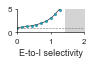

In [13]:
# Fig 4d top: E-to-I cut relative decoding accuracy
fig = figure(figsize=(1.4,1))
#ax = fig.add_subplot(1,1,1)
ax = fig.add_subplot(1,1,1)
format_axes(ax, '0','0')

matplotlib.rcParams['font.sans-serif']=['Arial']
matplotlib.rcParams['mathtext.fontset'] = 'custom'
matplotlib.rcParams['mathtext.rm'] = 'Arial'

black = '#313333'
colors = ['#086096','w','#c93a60','#851835']
cm = define_colormap(colors,100)

limx = [0,2]
#limx = [-0.05,1.2]
limy1,limy2 = 0.,5.

n = 200
D_IE_1 = linspace(D_IE[0], D_IE[-1], n)
Lim = (D_EE-1)/D_EI
D_IE_2 = linspace(D_IE[0], D_IE[-1], nsim)


for i in range(len(D_EI)):
    plot(D_IE_1, ((decodacc_E - 0.5) / (decodacc_E_0 - 0.5))[:, i], lw=.7, color=black)
    plot(D_IE_2, ((decodacc_E_sim - 0.5) / (decodacc_E_0_sim - 0.5))[:, i], '.', \
        markeredgewidth=0.2, markeredgecolor='k', markersize=5, color='#0db0d1')
#     ysim = ((decodacc_E_sim - 0.5) / (decodacc_E_0_sim - 0.5))[:, i]
#     plt.scatter(D_IE_2, ysim, c=ysim, s=10, linewidths = 0.5, edgecolors='k',cmap=cm)

plot([0,2],[1,1],'--',lw=0.6, color='grey')
a = abs(D_EI[0])
fill_between([Lim[0], 2], [limy1, limy1], [limy2,limy2], color='#d4d4d4')

xlabel(r'E-to-I selectivity')
#ylabel('Rel. decod. \naccuracy')
plt.xlim(limx)
yticks([0,5])
plt.ylim([limy1,limy2])
plt.xticks([0,1,2])
tight_layout()

plt.savefig(figsDir+'4d_top_rel_decoding_accuracy_IE_cut.pdf',bbox_inches='tight')

In [14]:
# Set up I-to-E cuts
S_EE = 0.
S_EI = 2
S_IE = 2
S_II = 0.

n = 200
D_EE = S_EE
# D_EI = linspace(-S_EI, S_EI, n)
D_EI = linspace(-2, 2, n)
D_IE = array([1])
D_II = 0.

decodacc_E       = empty((len(D_IE),len(D_EI)))
decodacc_EI      = empty((len(D_IE),len(D_EI)))
decodacc_E1      = empty((len(D_IE),len(D_EI)))
decodacc_E2      = empty((len(D_IE),len(D_EI)))
decodacc_I1      = empty((len(D_IE),len(D_EI)))
decodacc_I2      = empty((len(D_IE),len(D_EI)))

decodacc_E_0     = empty((len(D_IE),len(D_EI)))
decodacc_EI_0    = empty((len(D_IE),len(D_EI)))
decodacc_E1_0    = empty((len(D_IE),len(D_EI)))
decodacc_E2_0    = empty((len(D_IE),len(D_EI)))
decodacc_I1_0    = empty((len(D_IE),len(D_EI)))
decodacc_I2_0    = empty((len(D_IE),len(D_EI)))


N = 4
sigma_input = 0
sigma_obs = 2
R0 = zeros(N)
f = lambda x:x

for i_EI in range(len(D_EI)):
    for i_IE in range(len(D_IE)):

        if 1 + D_EI[i_EI] * D_IE[i_IE] - D_EE < 1e-10:
            decodacc_EI[i_IE, i_EI]     = nan
            decodacc_E[i_IE, i_EI]      = nan
            decodacc_EI_0[i_IE, i_EI]   = nan
            decodacc_E_0[i_IE, i_EI]    = nan

            decodacc_E1[i_IE, i_EI]   = nan
            decodacc_E2[i_IE, i_EI]   = nan
            decodacc_E1_0[i_IE, i_EI] = nan
            decodacc_E2_0[i_IE, i_EI] = nan

            decodacc_I1[i_IE, i_EI]   = nan
            decodacc_I2[i_IE, i_EI]   = nan
            decodacc_I1_0[i_IE, i_EI] = nan
            decodacc_I2_0[i_IE, i_EI] = nan

        else:
            S    = array([[S_EE, -S_EI], [S_IE, -S_II]])
            D    = array([[D_EE, -D_EI[i_EI]], [D_IE[i_IE], -D_II]])
            Win  = 0.5 * (S + D)
            Wout = 0.5 * (S - D)

            J    = block([[Win, Wout], [Wout, Win]])
            if max(eigvals(J).real)>1:
                print('Unstable!')

            Net = RecurrentNet(J, sigma_input)
            _ = Net.covariance()
            dh1 = array([1,0,0,0])
            dh2 = array([0,0,1,0])
            dh = dh1 - dh2

            cov = sigma_obs**2 * eye(N)

            decodacc_EI[i_IE, i_EI], _ = Net.compute_acc_analytical_obsnoise(dh, cov)
            decodacc_E[i_IE, i_EI],  _ = Net.compute_acc_analytical_obsnoise(dh, cov, idx = [0,2])
            # decodacc_E1[i_IE, i_EI], _ = Net.compute_acc_analytical(dh, idx = [0])
            # decodacc_E2[i_IE, i_EI], _ = Net.compute_acc_analytical(dh, idx=[2])
            # decodacc_I1[i_IE, i_EI], _ = Net.compute_acc_analytical(dh, idx=[1])
            # decodacc_I2[i_IE, i_EI], _ = Net.compute_acc_analytical(dh, idx=[3])

            J = zeros((N,N))
            Net = RecurrentNet(J, sigma_input)
            _ = Net.covariance()
            decodacc_EI_0[i_IE, i_EI], _ = Net.compute_acc_analytical_obsnoise(dh, cov)
            decodacc_E_0[i_IE, i_EI],  _ = Net.compute_acc_analytical_obsnoise(dh, cov, idx=[0, 2])
            # decodacc_E1_0[i_IE, i_EI], _ = Net.compute_acc_analytical(dh, idx=[0])
            # decodacc_E2_0[i_IE, i_EI], _ = Net.compute_acc_analytical(dh, idx=[2])
            # decodacc_I1_0[i_IE, i_EI], _ = Net.compute_acc_analytical(dh, idx=[1])
            # decodacc_I2_0[i_IE, i_EI], _ = Net.compute_acc_analytical(dh, idx=[3])

##
# set parameters
T = 200
nsteps = 2000
t = linspace(0, T, nsteps)
N = 4
ntrials = 5000
R0 = zeros(N)
f = lambda x:x


nsim = 15
D_EI = linspace(D_EI[0], D_EI[-1], nsim)

decodacc_E_sim       = empty((len(D_IE),len(D_EI)))
decodacc_EI_sim      = empty((len(D_IE),len(D_EI)))
decodacc_E1_sim      = empty((len(D_IE),len(D_EI)))
decodacc_E2_sim      = empty((len(D_IE),len(D_EI)))
decodacc_I1_sim      = empty((len(D_IE),len(D_EI)))
decodacc_I2_sim      = empty((len(D_IE),len(D_EI)))

h1 = array([1,0,0,0])
h2 = array([0,0,1,0])
h1 = h1 / linalg.norm(h1-h2)
h2 = h2 / linalg.norm(h1-h2)

# compute decoding accuracy WITHOUT recurrent connections using single-trial simulations
input = outer(h1, ones(nsteps))
pars = {'N': N, 't':t, 'R0':zeros(N), 'J':zeros((N,N)), 'I':input, 'sigma':sigma_input, 'f': lambda x:x}
R = simulate_rate_model(pars)
fp_1 = R[:,-1]
R_singletrials_1 = outer(fp_1, ones(ntrials)) + random.normal(0, sigma_obs, (N, ntrials))

# set second input and compute fixed point
input = outer(h2, ones(nsteps))
pars = {'N': N, 't': t, 'R0': zeros(N), 'J': zeros((N,N)), 'I': input, 'sigma': sigma_input, 'f': lambda x:x}
R = simulate_rate_model(pars)
fp_2 = R[:, -1]
R_singletrials_2 = outer(fp_2, ones(ntrials)) + random.normal(0, sigma_obs, (N, ntrials))

S = hstack((ones(ntrials), -ones(ntrials)))
R = hstack((R_singletrials_1, R_singletrials_2))
clf = LinearSVM(R,S)
clf_E = LinearSVM(R[[0,2],:], S)
clf.set_K(5)
clf_E.set_K(5)
decodacc_EI_0_sim  = mean(clf.get_accuracy())
decodacc_E_0_sim   = mean(clf_E.get_accuracy())


# compute decoding accuracy WITH recurrent connections using single-trial simulations
for i_IE in range(len(D_IE)):
    for i_EI in range(len(D_EI)):
        print(i_EI)

        # set connectivity matrix
        S = array([[S_EE, -S_EI], [S_IE, -S_II]])
        D = array([[D_EE, -D_EI[i_EI]], [D_IE[i_IE], -D_II]])
        Win = 0.5 * (S + D)
        Wout = 0.5 * (S - D)
        J = block([[Win, Wout], [Wout, Win]])
        d = max(eigvals(J).real)

        if 1+D_EI[i_EI]*D_IE[i_IE]-D_EE < 1e-10:
            decodacc_EI_sim[i_IE, i_EI] = nan
            decodacc_E_sim[i_IE, i_EI]  = nan
            decodacc_E1_sim[i_IE, i_EI] = nan
            decodacc_E2_sim[i_IE, i_EI] = nan
            decodacc_I1_sim[i_IE, i_EI] = nan
            decodacc_I2_sim[i_IE, i_EI] = nan

        else:
            print(d)

            # set first input and compute fixed point
            input = outer(h1, ones(nsteps))
            pars = {'N': N, 't':t, 'R0':zeros(N), 'J':J, 'I':input, 'sigma':sigma_input, 'f': lambda x:x}
            R = simulate_rate_model(pars)
            fp_1 = R[:,-1]
            R_singletrials_1 = outer(fp_1, ones(ntrials)) + random.normal(0, sigma_obs, (N, ntrials))

            # set second input and compute fixed point
            input = outer(h2, ones(nsteps))
            pars = {'N': N, 't': t, 'R0': zeros(N), 'J': J, 'I': input, 'sigma': sigma_input, 'f': lambda x:x}
            R = simulate_rate_model(pars)
            fp_2 = R[:, -1]
            R_singletrials_2 = outer(fp_2, ones(ntrials)) + random.normal(0, sigma_obs, (N, ntrials))


            S = hstack((ones(ntrials), -ones(ntrials)))
            R = hstack((R_singletrials_1, R_singletrials_2))
            clf = LinearSVM(R,S)
            clf_E = LinearSVM(R[[0,2],:], S)
            clf_E1 = LinearSVM(R[[0], :], S)
            clf_E2 = LinearSVM(R[[2],:], S)
            clf_I1 = LinearSVM(R[[1], :], S)
            clf_I2 = LinearSVM(R[[3], :], S)
            clf.set_K(10)
            clf_E.set_K(10)
            clf_E1.set_K(10)
            clf_E2.set_K(10)
            clf_I1.set_K(10)
            clf_I2.set_K(10)
            decodacc_EI_sim[i_IE, i_EI]  = mean(clf.get_accuracy())
            decodacc_E_sim[i_IE, i_EI]   = mean(clf_E.get_accuracy())
            # decodacc_E1_sim[i_IE, i_EI] = mean(clf_E1.get_accuracy())
            # decodacc_E2_sim[i_IE, i_EI] = mean(clf_E2.get_accuracy())
            # decodacc_I1_sim[i_IE, i_EI] = mean(clf_I1.get_accuracy())
            # decodacc_I2_sim[i_IE, i_EI] = mean(clf_I2.get_accuracy())


0
1
2
3
4
0.9258200997725515
5
0.7559289460184547
6
0.5345224838248488
7
3.6196515679232367e-09
8
1.3877787807814457e-16
9
4.1986725672294305e-139
10
1.942890293094024e-16
11
0.0
12
0.0
13
0.0
14
0.0


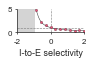

In [15]:
# Fig 4d bottom: I-E cut rel decoding accuracy
fig = figure(figsize=(1.4,1))
ax = fig.add_subplot(1,1,1)
format_axes(ax, '0', '0')
matplotlib.rcParams['font.sans-serif']=['Arial']
matplotlib.rcParams['mathtext.fontset'] = 'custom'
matplotlib.rcParams['mathtext.rm'] = 'Arial'
black = '#313333'
colors = ['#086096','w','#c93a60','#851835']
cm = define_colormap(colors,100)

#limx = [0,2]
limx = [-1.2, 1.2]
limx = [-2, 2]
#limy1,limy2 = 0.,3.
limy1,limy2 = 0.,5.

n = 200
D_EI_1 = linspace(D_EI[0], D_EI[-1], n)
Lim = (D_EE-1)/D_IE
D_EI_2 = linspace(D_EI[0], D_EI[-1], nsim)

plot([0,0],[0,limy2],'--',lw=0.6, color='grey')
plot([-2,2],[1,1],'--',lw=0.6, color='grey')

for i in range(len(D_IE)):
    plot(D_EI_1, ((decodacc_E - 0.5) / (decodacc_E_0 - 0.5))[i,:], lw=0.5, color=black)
    plot(D_EI_2, ((decodacc_E_sim - 0.5) / (decodacc_E_0_sim - 0.5))[i,:], '.', \
         markeredgewidth=0.2, markeredgecolor='k', markersize=5, color='#e85177')
#     ysim = ((decodacc_E_sim - 0.5) / (decodacc_E_0_sim - 0.5))[i,:]
#     plt.scatter(D_EI_2, ysim, c=ysim, s=10, linewidths = 0.5, edgecolors='k',cmap=cm)

a = abs(D_EI[0])
fill_between([-2,-1], [limy1, limy1], [limy2,limy2], color='#d4d4d4')

plt.xlabel('I-to-E selectivity')
#plt.ylabel('Rel. decod. \naccuracy')
plt.xlim(limx)
#yticks([0,1,2,3])
plt.yticks([0,limy2])
plt.yticks([0,5])
plt.ylim([limy1,limy2])
xticks([-2,0,2])
#xticks([-1,0,1])
tight_layout()
plt.savefig(figsDir+'4d_bottom_rel_decoding_accuracy_EI_cut.pdf',bbox_inches='tight')